In [1]:

import gc
import glob
import logging
import os
import random
import re
import sys
import time
import warnings
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display
import os.path
import joblib
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
# data_dict = np.load('/kaggle/input/train-data-npy/train_data.npy', allow_pickle=True).item()
data_dict = np.load('train_data.npy', allow_pickle=True).item()

X_list = []
y_list = []
for fid, content in data_dict.items():
    mel_2d = content['data']  # shape (128,256)
    label_str = content['label']


    mel_1d = mel_2d.flatten()

    X_list.append(mel_1d)
    y_list.append(label_str)

X_array = np.array(X_list)  # shape (N, 128*256)
y_array = np.array(y_list)  # shape (N,)

print("X_array shape:", X_array.shape)   # e.g. (N, 32768)
print("y_array shape:", y_array.shape)   # e.g. (N,)
print("Example label:", y_array[0])

X_array shape: (28564, 32768)
y_array shape: (28564,)
Example label: 1139490


In [3]:


X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_array, y_array, stratify=y_array, test_size=0.2, random_state=42
)

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

pca = PCA(n_components=34)
X_train_pca = pca.fit_transform(X_train_raw)
X_test_pca = pca.transform(X_test_raw)

In [4]:
def to_onehot(y, n_classes):
    y_bin = np.zeros((len(y), n_classes))
    for i, label in enumerate(y):
        y_bin[i, label] = 1
    return y_bin
#from ass2
def plot_roc(classes, y_true_bin, y_score):
    fpr_all = []
    tpr_all = []
    auc_all = []
    
    plt.figure(figsize=(10, 8))
    
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.5)
        
        fpr_all.append(fpr)
        tpr_all.append(tpr)
        auc_all.append(roc_auc)
    valid_indices = [i for i, a in enumerate(auc_all) if not np.isnan(a)]

    all_fpr = np.unique(np.concatenate([fpr_all[i] for i in valid_indices]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in valid_indices:
        mean_tpr += interp(all_fpr, fpr_all[i], tpr_all[i])
    
    mean_tpr /= len(valid_indices)
    auc_val = auc(all_fpr, mean_tpr)
    

    macro_auc = np.nanmean(auc_all)
   
    
    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(macro_auc, auc_val))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    
    return macro_auc, auc_all

# BNB

In [5]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
X_trainB = (X_train_pca > np.median(X_train_pca, axis=0)).astype(int)
X_testB = (X_test_pca > np.median(X_train_pca, axis=0)).astype(int)
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1, 2, 5, 10, 20, 50, 100]
}
BNB = GridSearchCV(BernoulliNB(),param_grid=param_grid,cv=5,scoring='accuracy', n_jobs=-1)
BNB.fit(X_trainB, y_train)
y_pred = BNB.predict(X_testB)
acc = accuracy_score(y_test, y_pred)
print("best:", BNB.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(BNB.best_estimator_, "BNB.pkl")
print(BNB)

best: {'alpha': 5}
acc: 0.0824435497987047
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.33      1.00      0.50         1
           9       0.00      0.00      0.00         1
          12       0.06      0.40      0.10        15
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         3
          19       0.00      0.00     

mcauc: 0.7367
0: AUC = nan
1: AUC = 0.9998
2: AUC = 0.8778
3: AUC = 0.3866
4: AUC = 1.0000
5: AUC = 0.9998
6: AUC = 0.9954
7: AUC = 0.9995
8: AUC = 0.9998
9: AUC = 0.9697
10: AUC = nan
11: AUC = nan
12: AUC = 0.9329
13: AUC = 0.9045
14: AUC = 0.7732
15: AUC = 0.8077
16: AUC = 0.3557
17: AUC = 0.9692
18: AUC = 0.3896
19: AUC = 0.7004
20: AUC = nan
21: AUC = 0.7800
22: AUC = 0.7174
23: AUC = nan
24: AUC = nan
25: AUC = 0.6513
26: AUC = nan
27: AUC = nan
28: AUC = 1.0000
29: AUC = 0.9391
30: AUC = 0.9089
31: AUC = 0.8381
32: AUC = 0.9989
33: AUC = nan
34: AUC = 0.9245
35: AUC = 0.9951
36: AUC = 0.5942
37: AUC = 0.4240
38: AUC = 0.8232
39: AUC = nan
40: AUC = 0.8442
41: AUC = 0.6134
42: AUC = 0.9361
43: AUC = 0.7100
44: AUC = 0.6908
45: AUC = 0.8516
46: AUC = 0.9998
47: AUC = 0.3406
48: AUC = nan
49: AUC = nan
50: AUC = nan
51: AUC = 0.7707
52: AUC = nan
53: AUC = 0.7989
54: AUC = 0.9993
55: AUC = 0.9987
56: AUC = 0.7983
57: AUC = nan
58: AUC = 0.7327
59: AUC = 1.0000
60: AUC = 0.7568
61: 

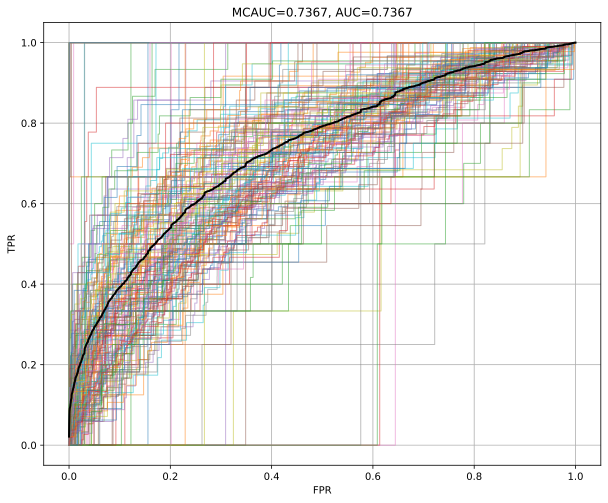

In [26]:

y_train_proba = BNB.predict_proba(X_trainB)
y_test_proba = BNB.predict_proba(X_testB)



classes = BNB.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")

# Multinomial Naive Bayes

best: {'alpha': 20}
acc: 0.06984071416068616
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.33      1.00      0.50         1
           9       0.00      0.00      0.00         1
          12       0.10      0.20      0.14        15
          13       0.00      0.00      0.00         9
          14       1.00      0.09      0.17        11
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         3
          19       0.00      0.00   

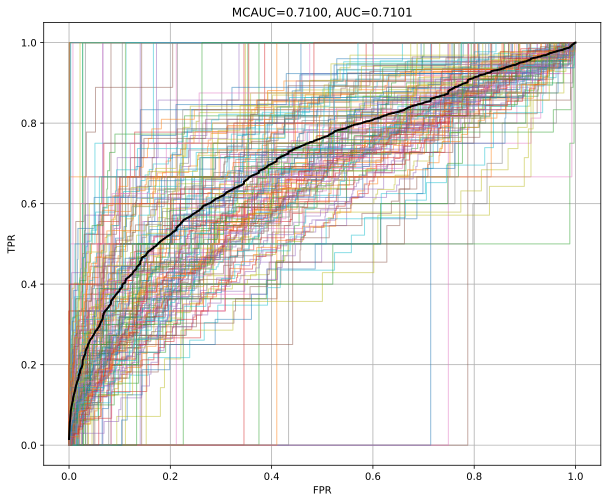

In [27]:
from sklearn.naive_bayes import MultinomialNB 

X_train_mnb = X_train_pca - X_train_pca.min(axis=0)  
X_test_mnb = X_test_pca - X_train_pca.min(axis=0)  
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1, 2, 5, 10, 20, 50, 100]
}

MNB = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
MNB.fit(X_train_mnb, y_train)
y_pred = MNB.predict(X_test_mnb)
acc = accuracy_score(y_test, y_pred)
print("best:", MNB.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(MNB.best_estimator_, "MNB.pkl")
print(MNB)

y_train_proba = MNB.predict_proba(X_train_mnb)
y_test_proba = MNB.predict_proba(X_test_mnb)
classes = MNB.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")

# adaboost

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best: {'n_estimators': 200, 'learning_rate': 0.5}
acc: 0.040959215823560303
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         

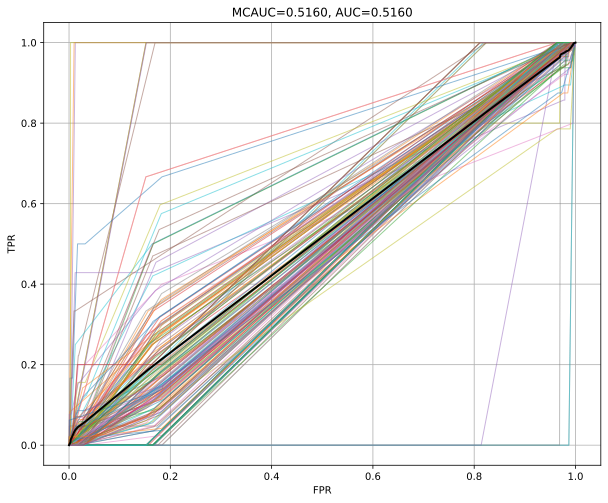

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV  

param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

base = DecisionTreeClassifier(max_depth=1)


adaboost = RandomizedSearchCV(AdaBoostClassifier(estimator=base), param_distributions=param_distributions, n_iter=10,  cv=5,  scoring='accuracy', n_jobs=-1,verbose=1)

adaboost.fit(X_train_pca, y_train) 


y_pred = adaboost.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print("best:", adaboost.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(adaboost.best_estimator_, "adaboost.pkl")
print(adaboost)


y_train_proba = adaboost.predict_proba(X_train_pca)
y_test_proba = adaboost.predict_proba(X_test_pca)
classes = adaboost.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")

# KNN

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
acc: 0.11570103273236478
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       0.00      0.00      0.00         1
          12       0.50      0.53      0.52        15
          13       0.50      0.11      0.18         9
          14       0.50      0.09      0.15        11
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00         1
          17       0.00      0

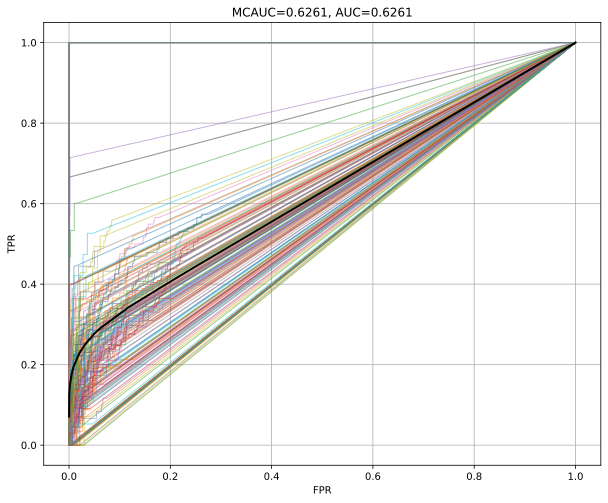

In [7]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

KNN = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
KNN.fit(X_train_pca, y_train)
y_pred = KNN.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print("best:", KNN.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(KNN.best_estimator_, "KNN.pkl")
print(KNN)

y_train_proba = KNN.predict_proba(X_train_pca)
y_test_proba = KNN.predict_proba(X_test_pca)

classes = KNN.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")

# SVM

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
acc: 0.06423945387712235
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          12       1.00      0.13      0.24        15
          13       1.00      0.11      0.20         9
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1


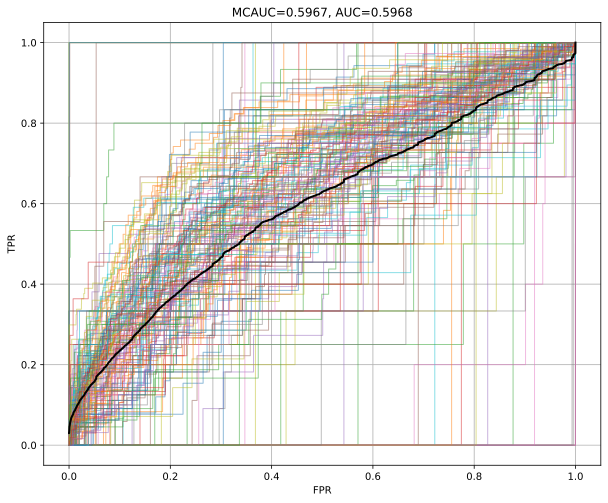

In [7]:
from sklearn.svm import SVC  

param_grid = {
    'C': [0.01,0.1, 1,  10, 100],
    'gamma': [ 'auto',],
    'kernel': ['rbf']  
}

SVM = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,verbose=True)
SVM.fit(X_train_pca, y_train)
y_pred = SVM.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print("best:", SVM.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(SVM.best_estimator_, "SVM.pkl")
print(SVM)


y_train_proba = SVM.predict_proba(X_train_pca)
y_test_proba = SVM.predict_proba(X_test_pca)

classes = SVM.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")

# Decision tree

Fitting 5 folds for each of 90 candidates, totalling 450 fits
best: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
acc: 0.060388587432172236
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.50      0.50      0.50         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.23      0.20      0.21        15
          13       0.11      0.11      0.11         9
       

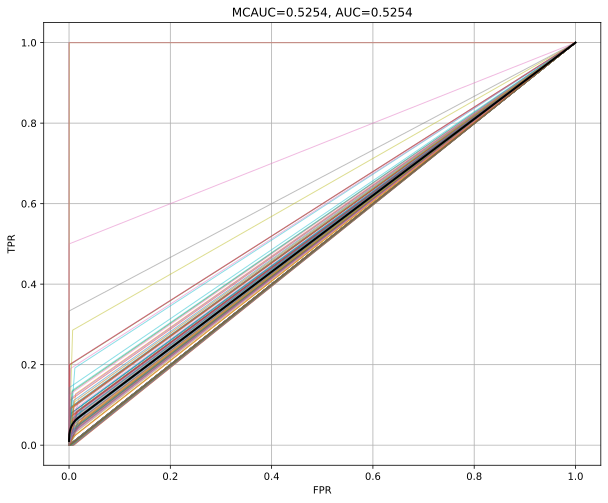

In [5]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

DT = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
DT.fit(X_train_pca, y_train)
y_pred = DT.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print("best:", DT.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(DT.best_estimator_, "DecisionTree.pkl")
print(DT)

y_train_proba = DT.predict_proba(X_train_pca)
y_test_proba = DT.predict_proba(X_test_pca)

classes = DT.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")

# MLP

Fitting 5 folds for each of 24 candidates, totalling 120 fits
best: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200}
acc: 0.15718536670750918
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.50      1.00      0.67         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          12       0.35      0.47      0.40        15
          13       0.67      0.44      0.53         9
          14       0.00      0.00      0.00        11
          15       0.00      0.00  

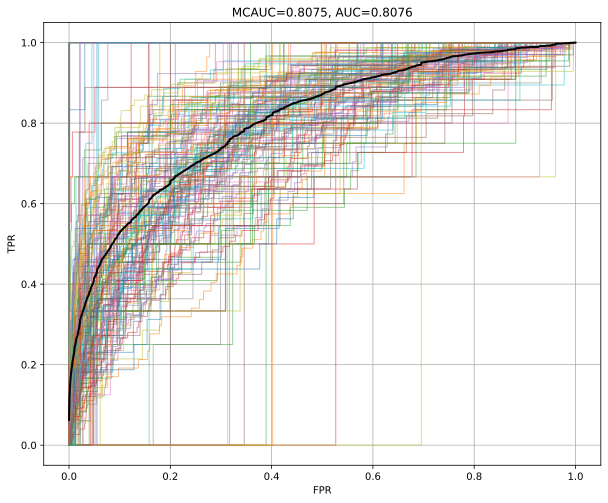

In [6]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu',],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200] 
}

MLP = GridSearchCV(MLPClassifier(random_state=42, early_stopping=True), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
MLP.fit(X_train_pca, y_train)
y_pred = MLP.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print("best:", MLP.best_params_)
print("acc:", acc)
print(classification_report(y_test, y_pred))
joblib.dump(MLP.best_estimator_, "MLP.pkl")
print(MLP)

y_train_proba = MLP.predict_proba(X_train_pca)
y_test_proba = MLP.predict_proba(X_test_pca)

classes = MLP.classes_
n_classes = len(classes)

y_train_bin = to_onehot(y_train, n_classes)
y_test_bin = to_onehot(y_test, n_classes)

macro_auc, class_aucs = plot_roc(classes, y_test_bin, y_test_proba)
print(f"mcauc: {macro_auc:.4f}")
for i, (c, auc_val) in enumerate(zip(classes, class_aucs)):
    print(f"{c}: AUC = {auc_val:.4f}")